In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib ipympl
# %matplotlib qt
import sys
sys.path.append('C:\code\qdc2')

import numpy as np
from numpy.fft import fft2, fftshift
import matplotlib.pyplot as plt
from fiber import Fiber

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# ------------------- parameters -------------------
λ_sig   = 0.808      # µm
core_d  = 50         # µm
NA      = 0.20
grid_n  = 128

# ------------------- fiber & modes -------------------
fib = Fiber(wl=λ_sig, diameter=core_d, NA=NA, npoints=grid_n, autosolve=True)
dx  = fib.dx
dq  = 2*np.pi / (grid_n * dx)
nq  = grid_n**2
Mxy = fib.modes.getModeMatrix()
N_modes = Mxy.shape[1]
print(f"Guided modes: {N_modes}")

# ------------------- FFT with norm -------------------
F = np.empty((N_modes, nq), dtype=np.complex64)
for k in range(N_modes):
    m_xy = Mxy[:, k].reshape(grid_n, grid_n)
    F[k] = fftshift(fft2(m_xy, norm='ortho')).ravel()

# ------------------- q-space coordinates -------------------
qx_1d = (np.arange(grid_n) - grid_n//2) * dq
Qx, Qy = np.meshgrid(qx_1d, qx_1d, indexing='ij')
qx_f, qy_f = Qx.ravel().astype(np.float32), Qy.ravel().astype(np.float32)

print(f"q-space range: [{qx_1d.min():.3f}, {qx_1d.max():.3f}] × dq = {dq:.6f}")

Guided modes: 190
q-space range: [-6.384, 6.284] × dq = 0.099746


In [3]:

# ------------------- SPDC kernel -------------------
use_delta_kernel = True  # toggle delta-function kernel test
magnification = 20
real_space_sigma = 1000.0 / magnification if not use_delta_kernel else 100e12
sigma     = 2 / real_space_sigma 
λ_p       = 0.405
n_crystal = 1.8
L_cr      = 2000.0 if not use_delta_kernel else 1e-13
k_p       = 2*np.pi * n_crystal / λ_p
b2        = (L_cr / (4 * k_p)) / magnification**2 
chunk   = 128         # Reduced chunk size for memory efficiency


print(f"SPDC parameters: σ={sigma:.1e}, b²={b2:.1e}")

dq2 = dq**2
C = np.zeros((N_modes, N_modes), dtype=np.complex64)

print(f"Computing 4D integral...")
print(f"Grid points: {nq} × {nq} = {nq**2:.0e}")

# Method: chunk over qi, vectorize over qs
for qi_start in range(0, nq, chunk):
    qi_end = min(qi_start + chunk, nq)
    qi_chunk_size = qi_end - qi_start
    
    # Current qi coordinates
    qix_chunk = qx_f[qi_start:qi_end]  # shape: (chunk,)
    qiy_chunk = qy_f[qi_start:qi_end]
    
    # All qs coordinates 
    qsx_all = qx_f[:, None]  # shape: (nq, 1)
    qsy_all = qy_f[:, None]
    
    # Broadcast qi coordinates
    qix_bc = qix_chunk[None, :]  # shape: (1, chunk)
    qiy_bc = qiy_chunk[None, :]
    
    # Compute ψ(qs, qi) for all qs and current qi chunk
    # Shape: (nq_qs, qi_chunk_size)
    psi_chunk = np.exp(
        -((qsx_all + qix_bc)**2 + (qsy_all + qiy_bc)**2) / (2 * sigma**2)
        - b2 * ((qsx_all - qix_bc)**2 + (qsy_all - qiy_bc)**2)
    ).astype(np.complex64)
    
    # For each mode pair (k, k'), compute:
    # ∫ F*_k(qs) ψ(qs,qi) F_k'(qi) dqs
    # This is: F*[k,:] @ psi_chunk @ F[k',qi_chunk]
    
    # F_conj @ psi_chunk gives (N_modes, qi_chunk_size)
    temp = F.conj() @ psi_chunk  # shape: (N_modes, qi_chunk_size)
    
    # temp @ F[:, qi_start:qi_end].T gives (N_modes, N_modes)
    C += temp @ F[:, qi_start:qi_end].T
        
    
    if qi_start % (60*chunk) == 0:
        print(f"Progress: {qi_start/nq*100:.1f}%")

C *= dq2**2

print("Integration complete.")

SPDC parameters: σ=2.0e-14, b²=2.2e-18
Computing 4D integral...
Grid points: 16384 × 16384 = 3e+08
Progress: 0.0%
Progress: 46.9%
Progress: 93.8%
Integration complete.



Diagnostics:
max |diag|: 9.824e-05
min |diag|: 8.534e-05
max |off-diag|: 2.397e-05
max |off-diag| / max |diag| = 2.440e-01
||C−C†|| / ||C|| = 1.668e-07
Schmidt number ≈ 189.9

Delta kernel check:
Diagonal uniformity: std/mean = 3.496e-02
Expected: off-diagonal << diagonal

Total norm ||C|| = 1.355e-03
Largest element: 9.824e-05


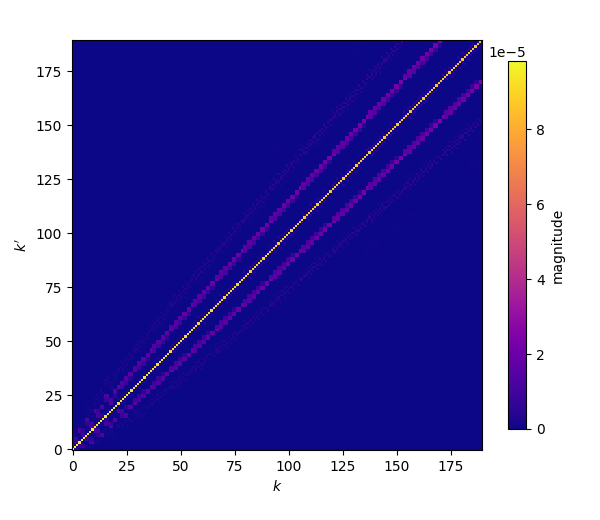

In [4]:

# ------------------- visualization -------------------
fig, ax = plt.subplots(figsize=(6,5.2))
im = ax.imshow(np.abs(C), origin='lower', cmap='plasma', interpolation='nearest') # , vmax=5e-5)
ax.set_xlabel('$k$')
ax.set_ylabel("$k'$")
plt.colorbar(im, ax=ax, shrink=0.8, label='magnitude')
plt.tight_layout()

# ------------------- diagnostics -------------------
diag = np.abs(np.diag(C))
diag_max = diag.max()
diag_min = diag.min()
offdiag = np.abs(C - np.diag(np.diag(C)))
offmax = offdiag.max()

print(f"\nDiagnostics:")
print(f"max |diag|: {diag_max:.3e}")
print(f"min |diag|: {diag_min:.3e}")  
print(f"max |off-diag|: {offmax:.3e}")
print(f"max |off-diag| / max |diag| = {offmax/diag_max:.3e}")

herm = np.linalg.norm(C - C.conj().T) / np.linalg.norm(C)
print(f"||C−C†|| / ||C|| = {herm:.3e}")

s = np.linalg.svd(C, compute_uv=False)
K = (s.sum()**2)/(s@s)
print(f"Schmidt number ≈ {K:.1f}")

# Delta kernel check
if use_delta_kernel:
    print(f"\nDelta kernel check:")
    print(f"Diagonal uniformity: std/mean = {diag.std()/diag.mean():.3e}")
    print(f"Expected: off-diagonal << diagonal")

# Check for numerical issues
C_norm = np.linalg.norm(C)
print(f"\nTotal norm ||C|| = {C_norm:.3e}")
print(f"Largest element: {np.abs(C).max():.3e}")